In [113]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [114]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [115]:
chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
king_all_copy, king_data= load_data(ismael_path)
print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [116]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [117]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [118]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [119]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [120]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [121]:
master_data = master_data[132:]

In [122]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [123]:
master_data.reset_index(inplace=True)

In [124]:
master_data = master_data.drop(labels='index', axis=1)

In [125]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [126]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [127]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [128]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [129]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [130]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [131]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [132]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [133]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [134]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [135]:
master_data.to_csv('master_data.csv')

In [136]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

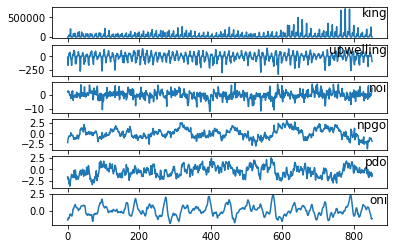

In [137]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [138]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [139]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [140]:
#create train, test, dev split
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [141]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/400
1/1 - 3s - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1925
Epoch 2/400
1/1 - 0s - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2052
Epoch 3/400
1/1 - 0s - loss: 0.0100 - root_mean_squared_error: 0.1001 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2190
Epoch 4/400
1/1 - 0s - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2262
Epoch 5/400
1/1 - 0s - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2264
Epoch 6/400
1/1 - 0s - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2219
Epoch 7/400
1/1 - 0s - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2152
Epoch 8/400
1/1 - 0s - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0433 - val_root_mean_square

Epoch 40/400
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2032
Epoch 41/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 42/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2013
Epoch 43/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2004
Epoch 44/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1997
Epoch 45/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1993
Epoch 46/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 47/400
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0398 - val_root_mea

Epoch 79/400
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1994
Epoch 80/400
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1994
Epoch 81/400
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 82/400
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 83/400
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1987
Epoch 84/400
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1985
Epoch 85/400
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1983
Epoch 86/400
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0393 - val_root_mea

Epoch 118/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949
Epoch 119/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948
Epoch 120/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947
Epoch 121/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945
Epoch 122/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943
Epoch 123/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 124/400
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1940
Epoch 125/400
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0376 - val_

Epoch 157/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899
Epoch 158/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1898
Epoch 159/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1897
Epoch 160/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1896
Epoch 161/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1896
Epoch 162/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 163/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 164/400
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0358 - val_

Epoch 196/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869
Epoch 197/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1868
Epoch 198/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1868
Epoch 199/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1867
Epoch 200/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 201/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 202/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 203/400
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0348 - val_

Epoch 235/400
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 236/400
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 237/400
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 238/400
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1841
Epoch 239/400
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 240/400
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1840
Epoch 241/400
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 242/400
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0338 - val_

Epoch 274/400
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 275/400
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 276/400
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 277/400
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 278/400
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1815
Epoch 279/400
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1815
Epoch 280/400
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814
Epoch 281/400
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0329 - val_

Epoch 313/400
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1792
Epoch 314/400
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 315/400
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 316/400
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1790
Epoch 317/400
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1789
Epoch 318/400
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 319/400
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1789
Epoch 320/400
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0318 - val_

Epoch 352/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1773
Epoch 353/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 354/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1765
Epoch 355/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1768
Epoch 356/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 357/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766
Epoch 358/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1761
Epoch 359/400
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0309 - val_

Epoch 391/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730
Epoch 392/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 393/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1753
Epoch 394/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1724
Epoch 395/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1747
Epoch 396/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1736
Epoch 397/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0809 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 398/400
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0305 - val_

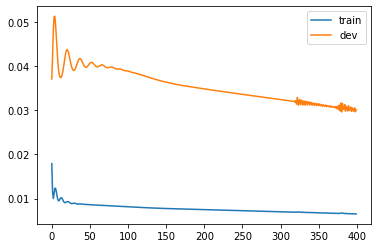

In [142]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(1))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=400, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [143]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [144]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [145]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [146]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

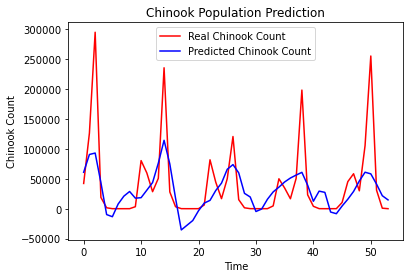

The test root mean squared error is 52234.98168851981.


In [147]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

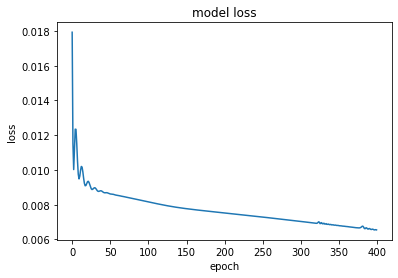

In [148]:
plot_loss(history)

In [149]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  414900
1  289925
2  368247
3  305041
    Count
0  488981
1  336030
2  381773
3  535746


In [150]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [151]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [152]:
return_rmse(actual, preds)

The test root mean squared error is 123512.56544072753.
